# Expirament 1

In [1]:
# 0

#Experiment 1: choose all or some of the likert scale questions, among all categories. 
# Likert only! Run PCA and see if we could get explained var > 70%/80% in the first 2/3 components. 
# Interpret results with LLM & save as md file

# Data wrangling
import pandas as pd
import numpy as np
from pathlib import Path
import re
from collections import defaultdict

# Modelling & preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

# Visualisation
import matplotlib.pyplot as plt

# OpenAI for auto-interpretation
import openai
import json
import keys       
from openai import OpenAI                

openai.api_key = keys.api_key   

# Misc
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import os

print("✅  Core libraries imported and OpenAI ready.")


from collections import Counter
df_all = pd.read_excel("data_processed/survey_dataframe.xlsx", engine="openpyxl")



✅  Core libraries imported and OpenAI ready.


### Load Survey

In [2]:
# 1
# Load survey dataframe & preview Likert structure


# 1️⃣  Load data
data_file = Path("data_processed/survey_dataframe.xlsx")        # adjust if your path differs
df = pd.read_excel(data_file, engine="openpyxl")

rows, cols = df.shape
print(f"✅  Loaded survey_dataframe.xlsx – {rows:,} rows × {cols:,} columns")

# 2️⃣  Detect Likert-style questions (0/1 dummies suffixed _1 … _5/6)
pattern = re.compile(r"^(?P<base>.+)_(?P<option>\d+)$")
option_map = defaultdict(set)

for col in df.columns:
    m = pattern.match(col)
    if m:
        option_map[m.group("base")].add(int(m.group("option")))

# Keep bases that have at least three of the true Likert options 1-5
likert_bases = {
    base: sorted(opts & {1, 2, 3, 4, 5})
    for base, opts in option_map.items()
    if len(opts & {1, 2, 3, 4, 5}) >= 3
}

print(f"🔍  Identified {len(likert_bases)} candidate Likert questions "
      f"having ≥3 of the 1-5 options")

# 3️⃣  Preview: list first 10 detected bases & show their raw dummy columns
for base, opts in list(likert_bases.items())[:10]:
    print(f"  • {base}: options {opts}")

if likert_bases:
    first_base = next(iter(likert_bases))
    dummy_cols = [c for c in df.columns if c.startswith(f"{first_base}_")]
    print(f"\nRaw dummy columns for base {first_base}: {dummy_cols}")
    display(df[dummy_cols].head())


✅  Loaded survey_dataframe.xlsx – 2,055 rows × 456 columns
🔍  Identified 67 candidate Likert questions having ≥3 of the 1-5 options
  • 360190: options [1, 2, 4]
  • 369184: options [1, 2, 3]
  • 369188: options [1, 2, 3]
  • 380308: options [2, 3, 4]
  • 380310: options [2, 3, 4, 5]
  • 380319: options [1, 2, 3, 4, 5]
  • 380323: options [1, 2, 3, 4]
  • 380437: options [1, 2, 3, 4, 5]
  • 380442: options [1, 2, 3, 4, 5]
  • 380448: options [1, 2, 3, 4, 5]

Raw dummy columns for base 360190: ['360190_1', '360190_2', '360190_4']


,360190_1,360190_2,360190_4
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


### Built Likert-Only Dataframe

In [3]:
# 2 ── Build a clean Likert-only 0–1 matrix (explicit 16 questions) ───────────
from pathlib import Path
import numpy as np
import pandas as pd

# ---------------------------------------------------------------------------
# 2.1  Exact base-ID list
# ---------------------------------------------------------------------------
LIKERT_BASE_IDS = [
    "391222","383198","383199","391201","391213",
    "380319","380514","405548","383195","380437",
    "397317","380448","380442","405583","405568","405978"
]

# ---------------------------------------------------------------------------
# 2.2  Make sure _1 … _5 columns exist for every ID (create zeros if absent)
# ---------------------------------------------------------------------------
for bid in LIKERT_BASE_IDS:
    for opt in range(1, 6):
        col = f"{bid}_{opt}"
        if col not in df.columns:
            df[col] = 0  # add an all-zero column

# ---------------------------------------------------------------------------
# 2.3  Reconstruct Likert scores (1-5)
# ---------------------------------------------------------------------------
likert_df = pd.DataFrame(index=df.index)

for bid in LIKERT_BASE_IDS:
    dummy_cols = [f"{bid}_{o}" for o in range(1, 6)]
    scores = (df[dummy_cols].values * np.arange(1, 6)).max(axis=1)
    likert_df[bid] = pd.Series(scores).replace(0, np.nan)   # 0 → NaN

print(f"✅  Likert matrix constructed: {likert_df.shape[0]} rows × {likert_df.shape[1]} questions")

# ---------------------------------------------------------------------------
# 2.4  Median-impute missing (still 1-5 scale)
# ---------------------------------------------------------------------------
likert_imputed = likert_df.apply(lambda col: col.fillna(col.median()), axis=0)

# ---------------------------------------------------------------------------
# 2.5  Rescale to 0–1   (x – 1) / 4
# ---------------------------------------------------------------------------
likert_scaled_01 = (likert_imputed - 1.0) / 4.0
likert_scaled_01 = likert_scaled_01.clip(0, 1)

# ---------------------------------------------------------------------------
# 2.6  Save and preview
# ---------------------------------------------------------------------------
out_dir = Path("data_processed"); out_dir.mkdir(parents=True, exist_ok=True)
scaled_path = out_dir / "likert_scaled_matrix.xlsx"
likert_scaled_01.to_excel(scaled_path, index=False, engine="openpyxl")
print(f"📁  0–1 scaled Likert matrix saved to: {scaled_path}")

summary = likert_scaled_01.describe().T[['mean', 'std', 'min', 'max']]
pd.set_option('display.max_rows', None)
display(summary)


✅  Likert matrix constructed: 2055 rows × 16 questions
📁  0–1 scaled Likert matrix saved to: data_processed\likert_scaled_matrix.xlsx


,mean,std,min,max
391222,0.039294,0.119108,0.0,1.00
383198,0.042092,0.144029,0.0,1.00
383199,0.225912,0.191637,0.0,1.00
391201,0.002599,0.034159,0.0,0.75
391213,0.137348,0.205713,0.0,1.00
380319,0.644647,0.256195,0.0,1.00
380514,0.151825,0.235464,0.0,1.00
405548,0.126034,0.220628,0.0,1.00
383195,0.138686,0.227545,0.0,1.00
380437,0.184915,0.252285,0.0,1.00


### Create PCA

In [4]:
# 3a ── Explicitly select the 16 confirmed Likert items for PCA ──────────────

# 1️⃣  Load the 0–1-scaled Likert matrix produced in Cell 2
file_path      = "data_processed/likert_scaled_matrix.xlsx"
likert_matrix  = pd.read_excel(file_path, engine="openpyxl")

# 2️⃣  ----- EXPLICIT column list (the 16 questions we validated) -----
cols_for_pca = [
    #'391222', 
    #'383198', 
    #'383199', 
    #'391201', 
    #'391213', 
    #'380319',
    '380514', 
    '405548', 
    '383195', 
    '380437', 
    #'397317', 
    '380448',
    #'380442', 
    #'405583', 
    '405568', 
    #'405978'
]

# 3️⃣  Build the DataFrame that will feed PCA
df_prepared_section_scores_only = likert_matrix[cols_for_pca].copy()

# 4️⃣  Quick sanity check
print("Columns selected for PCA:", len(cols_for_pca))
for c in cols_for_pca:
    print("  •", c)

print("\nShape of df_prepared_section_scores_only:",
      df_prepared_section_scores_only.shape)
display(df_prepared_section_scores_only.head())


Columns selected for PCA: 6
  • 380514
  • 405548
  • 383195
  • 380437
  • 380448
  • 405568

Shape of df_prepared_section_scores_only: (2055, 6)


,380514,405548,383195,380437,380448,405568
0,0.00,0.25,0.00,0.0,0.00,0.00
1,1.00,1.00,1.00,1.0,1.00,0.75
2,0.00,0.00,0.00,0.0,0.00,0.25
3,0.25,0.00,0.25,0.5,0.25,0.25
4,0.00,0.00,0.00,0.0,0.00,0.00


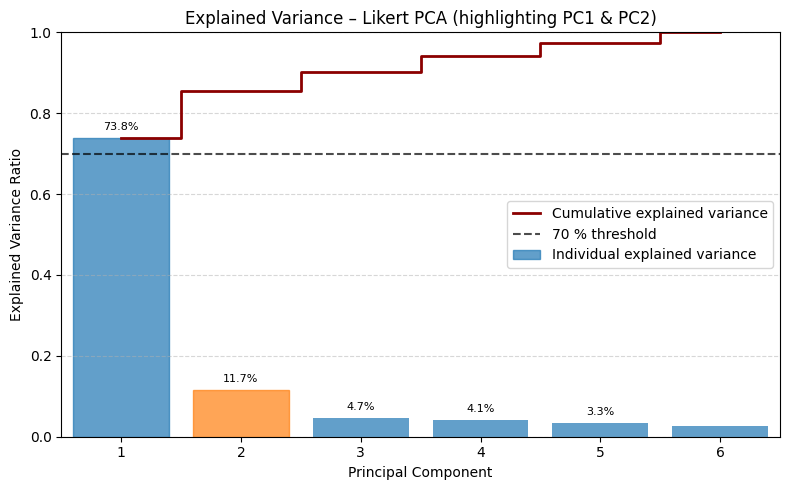

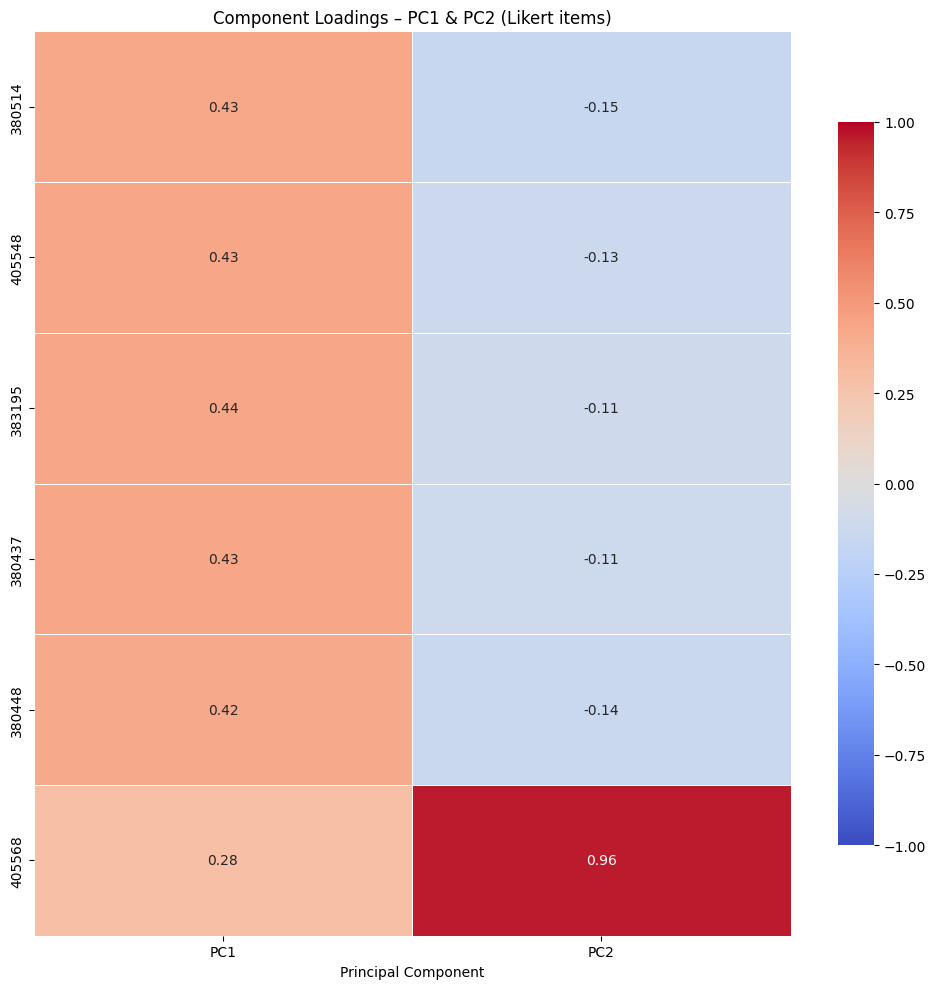

✅  PCA complete – focusing on PC1 & PC2. Charts saved in: Task1_Exp1_output


In [5]:
# 3b
# Robust-PCA workflow (30 Likert items) – focus on PC1 & PC2 ======




OUT_DIR = "Task1_Exp1_output"
os.makedirs(OUT_DIR, exist_ok=True)

# 1️⃣  Data block -------------------------------------------------------------
predictor_columns = df_prepared_section_scores_only.columns.tolist()
X_raw             = df_prepared_section_scores_only[predictor_columns]

# 2️⃣  Robust scaling
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# 3️⃣  PCA (keep all comps, but we’ll inspect only the first two)
pca                 = PCA()
scores              = pca.fit_transform(X_scaled)
explained_var       = pca.explained_variance_ratio_
cumulative_var      = np.cumsum(explained_var)

# 4️⃣  Explained-variance plot (show PC1 & PC2 bars more prominently)
plt.figure(figsize=(8, 5))
bars = plt.bar(
    np.arange(1, len(explained_var) + 1),
    explained_var,
    alpha=0.7,
    label='Individual explained variance'
)
# Highlight first two bars
bars[0].set_color('tab:blue'); bars[1].set_color('tab:orange')

plt.step(np.arange(1, len(cumulative_var) + 1),
         cumulative_var,
         where='mid',
         color='darkred',
         linewidth=2,
         label='Cumulative explained variance')

plt.axhline(y=0.70, linestyle='--', color='k', alpha=0.7, label='70 % threshold')
for i, v in enumerate(explained_var[:5]):           # label first few only
    plt.text(i + 1, v + 0.02, f'{v:.1%}', ha='center', fontsize=8)
plt.xlabel('Principal Component'); plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance – Likert PCA (highlighting PC1 & PC2)')
plt.xlim(0.5, len(explained_var) + 0.5)
plt.ylim(0, 1.0)
plt.legend(); plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/likert_pca_explained_variance_PC1_PC2.png", dpi=300)
plt.show()

# 5️⃣  Component-loading heatmap for PC1 & PC2 only ---------------------------
loading_df = pd.DataFrame(
    pca.components_[:2].T,                      # first two PCs
    index=predictor_columns,
    columns=['PC1', 'PC2']
)

plt.figure(figsize=(10, 10))
sns.heatmap(
    loading_df,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.6,
    cbar_kws={"shrink": .8}
)
plt.title('Component Loadings – PC1 & PC2 (Likert items)')
plt.xlabel('Principal Component'); plt.ylabel('')
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/likert_pca_component_loadings_PC1_PC2.png", dpi=300)
plt.show()

print("✅  PCA complete – focusing on PC1 & PC2. Charts saved in:", OUT_DIR)


### Package PCA Outputs

In [6]:
# 4
# PCA Setup & JSON Packaging (Likert experiment)


OUT_DIR = "Task1_Exp1_output"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------------------------------------------------------------------
# 1) Assemble the numeric matrix for PCA
#     → we already created df_prepared_section_scores_only in Cell 3
audit_data = df_prepared_section_scores_only.copy()    # shape: (rows, 30)

# 2) Robust-scale (median & IQR)  -------------------------------------------
scaler       = RobustScaler()
scaled_data  = scaler.fit_transform(audit_data)

# 3) PCA on scaled data  -----------------------------------------------------
pca          = PCA()          # keep all components
pca_scores   = pca.fit_transform(scaled_data)

# 4) Variance DataFrame  -----------------------------------------------------
expl_var     = pca.explained_variance_ratio_
cum_var      = np.cumsum(expl_var)

df_variance = pd.DataFrame({
    "Explained Variance":          expl_var,
    "Cumulative Explained Var":    cum_var
}, index=[f"PC{i+1}" for i in range(len(expl_var))])

# 5) Loadings DataFrame  -----------------------------------------------------
df_loadings = pd.DataFrame(
    pca.components_.T,
    index=audit_data.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Sort features by |PC1| for readability
df_loadings_sorted = df_loadings.loc[
    df_loadings["PC1"].abs().sort_values(ascending=False).index
]

# 6) Convert to JSON  --------------------------------------------------------
variance_json = json.dumps(df_variance.to_dict(), indent=2)
loadings_json = json.dumps(df_loadings_sorted.to_dict(orient="index"), indent=2)

# Optionally save JSON files for reuse
with open(f"{OUT_DIR}/likert_pca_variance.json", "w", encoding="utf-8") as f:
    f.write(variance_json)
with open(f"{OUT_DIR}/likert_pca_loadings.json", "w", encoding="utf-8") as f:
    f.write(loadings_json)

print("✅  Prepared PCA JSON payloads.")
print("• Variance JSON length:", len(variance_json))
print("• Loadings JSON length:", len(loadings_json))
print("Included columns (30 Likert items):")
for c in audit_data.columns:
    print("  •", c)


✅  Prepared PCA JSON payloads.
• Variance JSON length: 444
• Loadings JSON length: 1263
Included columns (30 Likert items):
  • 380514
  • 405548
  • 383195
  • 380437
  • 380448
  • 405568


In [7]:
# 5
# (fixed): OpenAI PCA Interpretation – PC1 & PC2 only ============



# --------------------------------------------------------------------------
# 1) Slice variance & loadings down to PC1 + PC2
df_variance_2 = df_variance.iloc[:2]
df_loadings_2 = df_loadings[["PC1", "PC2"]]

variance_json = json.dumps(df_variance_2.to_dict(), indent=2)
loadings_json = json.dumps(df_loadings_2.to_dict(orient="index"), indent=2)

# --------------------------------------------------------------------------
# 2) Build the prompt
prompt_text = f"""

### High Level Context ###
summary of the projecT: The mystery shopping survey template is designed to comprehensively evaluate a customer’s experience across multiple touchpoints with a luxury brand (e.g., Gucci), including website navigation, social media engagement, appointment booking, in-store service, digital content interaction, product availability scenarios, omnichannel consistency, and post-visit follow-up. The objective of the mystery shop is to assess the performance of client advisors and overall brand experience from a customer-centric perspective, focusing on interpersonal skills, product knowledge, proactivity, and the ability to build connection and inspire purchase decisions — while ensuring alignment with brand values and service standards. The survey emphasizes feedback on the Advisor’s behavior, communication, and service delivery, while excluding judgments about store location, pricing, or products themselves. Ultimately, the goal is to identify strengths and areas for improvement in the customer journey to enhance client retention, brand loyalty, and service excellence.




### High Level Description of the data ###

We have PCA results from a 30-item Likert survey dataset.

Below you will see the questions and they're loadings. Have in mind that the questions are sorted by question ID. For each question ID, below are the actual questions. The answers are encode likert scale. 
"380514": "Client-Advisor – “The advisor was able to build a connection with me”",
"405548": "Client-Advisor – “The advisor was proactive during the whole interaction”",
"383195": "Client-Advisor – “The advisor increased my interest for the products presented”",
"380437": "Client-Advisor – “I felt inspired by the advisor(s)”",
"380448": "Client-Advisor – “The advisor encouraged me to continue interacting with the brand”",
"405568": "Journey – “Communication from the brand was consistent throughout my journey”",


### PCA Loadings (PC1 & PC2) ###
{loadings_json}

### Explained Variance (PC1 & PC2) ###
{variance_json}

**Your tasks:**
1. Provide an executive summary of what PCA is and why we used it.
2. Describe in plain language what PC1 and PC2 represent and give each a short, interpretable name.
3. Suggest names for the four respondent segments formed by the quadrants of PC1 vs PC2.
4. Highlight any surprising findings (PC1 & PC2 only).
5. Offer 1–2 actionable recommendations for the product team.
6. Say whether the variance captured by PC1 & PC2 is satisfactory.

Respond in **markdown**.
"""

# --------------------------------------------------------------------------
# 3) Call the OpenAI chat API (>=1.0 syntax)
client = OpenAI(api_key=keys.api_key)

resp = client.chat.completions.create(
    model="o3",
    messages=[{"role": "user", "content": prompt_text}]
)

interpretation_md = resp.choices[0].message.content.strip()

interpretation_md = resp.choices[0].message.content.strip()

# --------------------------------------------------------------------------
# 4) Save the markdown summary
out_path = Path("Task1_Exp1_output/likert_pca_PC1_PC2.md")
out_path.write_text(interpretation_md, encoding="utf-8")

print(f"✔️  Saved interpretation → {out_path}")
print("Included features in loadings:", list(df_loadings_2.index))


✔️  Saved interpretation → Task1_Exp1_output\likert_pca_PC1_PC2.md
Included features in loadings: ['380514', '405548', '383195', '380437', '380448', '405568']


In [8]:
#  "391222": "Website – “I felt this experience increased my interest for the products”",
#  "383198": "Appointment booking – “I felt the appointment process was very smooth”",
#  "383199": "Social-media channel – “I felt this experience increased my interest for the products”",
#  "391201": "Website – “I felt the online checkout was simple and intuitive”",
#  "391213": "Client-Advisor – statement best describing intent to buy at the store",
#  "380319": "Store entrance – perceived level of traffic in the store",
# "380514": "Client-Advisor – “The advisor was able to build a connection with me”",
# "405548": "Client-Advisor – “The advisor was proactive during the whole interaction”",
# "383195": "Client-Advisor – “The advisor increased my interest for the products presented”",
# "380437": "Client-Advisor – “I felt inspired by the advisor(s)”",
#  "397317": "Client-Advisor – “The advisor attempted to close the sale convincingly”",
# "380448": "Client-Advisor – “The advisor encouraged me to continue interacting with the brand”",
#  "380442": "Client-Advisor – “My visit was better because I booked in advance”",
#  "405583": "Client-Advisor – “I was proactively engaged when I asked for an item seen online”",
# "405568": "Journey – “Communication from the brand was consistent throughout my journey”",
# "405978": "Coordinator – “I would recommend CXG to a friend”",


# Expirament 2

### Find Candidate Bases

In [9]:
# # 1

# #Experiment 2: choose another category, i.e. Introduction, Be a Host, Advocacy index, See the long term, etc. 
# # Preprocess chosen columns (numeric, likert, binary, multiple choice, but not open text).
# # Run PCA and see if we could get explained var > 70%/80% in the first 2/3 components. Interpret results with LLM & save as md file
 
 

# # Find candidate bases that have multiple columns


# pattern = re.compile(r"^(?P<base>\d+)_")         

# bases = []
# for col in df_all.columns:
#     m = pattern.match(col)
#     if m:
#         bases.append(m.group("base"))

# base_counts = Counter(bases)

# # Show bases that have at least N columns (N = 4 here; tweak as you like)
# N = 4
# candidates = {b: cnt for b, cnt in base_counts.items() if cnt >= N}

# print(f"{len(candidates)} bases have ≥{N} columns.\n")
# for b, cnt in sorted(candidates.items(), key=lambda kv: kv[1], reverse=True)[:20]:
#     print(f" • {b}  →  {cnt} columns")

# #add for it to write the text

### Extract Columns

In [10]:
# # 2 ── Build the modelling matrix for the chosen question block ──────────────
# # We’ll work with four specific bases: 405545, 394266, 380515, 405576
# # (Feel free to edit `bases_chosen` to any 1‒N list and the rest adapts.)

# # 1️⃣  Base IDs to analyse
# bases_chosen = ["405545", "394266", "380515", "405576"]    # ← edit as needed

# # 2️⃣  Grab columns that belong to those bases
# pattern   = r"^(?:" + "|".join(bases_chosen) + r")_"
# cols_block = [c for c in df_all.columns if re.match(pattern, c)]

# print(f"Found {len(cols_block)} columns for bases {bases_chosen}")
# df_block = df_all[cols_block].copy()

# # 3️⃣  Reconstruct Likert scores (bases that have ≥3 of the 5 options present)
# likert_pattern = re.compile(r"^(?P<base>\d+)_(?P<option>[1-5])$")
# likert_bases   = defaultdict(set)

# for col in cols_block:
#     m = likert_pattern.match(col)
#     if m:
#         likert_bases[m.group("base")].add(int(m.group("option")))

# likert_scores = pd.DataFrame(index=df_block.index)
# for base, opts in likert_bases.items():
#     if len(opts) >= 3:                                    # keep if at least 3 options exist
#         dummy_cols = [f"{base}_{o}" for o in opts]
#         scores = (df_block[dummy_cols].values * np.array(list(opts))).max(axis=1)
#         likert_scores[base] = pd.Series(scores).replace(0, np.nan)

# # median-impute + min-max scale to 0–1
# likert_scores = likert_scores.apply(lambda col: col.fillna(col.median()), axis=0)
# likert_scores = (likert_scores - 1) / 4

# # 4️⃣  Keep any remaining numeric (binary / multi-choice) columns
# other_numeric = (
#     df_block.drop(columns=sum([[f"{b}_{o}" for o in likert_bases[b]] for b in likert_bases], []),
#                   errors="ignore")
#              .select_dtypes(include="number")
# )

# # 5️⃣  Combine Likert + other numerics
# model_matrix = pd.concat([likert_scores, other_numeric], axis=1)

# print(f"✅  Modelling matrix ready → {model_matrix.shape[0]} rows × {model_matrix.shape[1]} cols")
# display(model_matrix.head())


### Build PCA

In [11]:
# # 3 ── Standard-Scaler PCA on the chosen bases  ────────────────────────────────
# # Works with whatever `bases_chosen` and `model_matrix` were built in Cell 2.


# from sklearn.preprocessing import StandardScaler      # ← switched scaler

# # ---------------------------------------------------------------------------
# # 1️⃣  House-keeping
# # ---------------------------------------------------------------------------
# OUT_DIR = "Task1_Exp2_output"
# os.makedirs(OUT_DIR, exist_ok=True)

# base_label = "_".join(bases_chosen)            # e.g. "405545_394266_380515_405576"

# # ---------------------------------------------------------------------------
# # 2️⃣  Standard scaling  →  PCA
# # ---------------------------------------------------------------------------
# X_scaled = StandardScaler().fit_transform(model_matrix)

# pca   = PCA()
# scores = pca.fit_transform(X_scaled)
# evr   = pca.explained_variance_ratio_
# cum   = evr.cumsum()

# # ---------------------------------------------------------------------------
# # 3️⃣  Scree / cumulative variance plot
# # ---------------------------------------------------------------------------
# plt.figure(figsize=(8, 5))
# bars = plt.bar(range(1, len(evr) + 1), evr, alpha=.7)
# if len(evr) >= 2:
#     bars[0].set_color('tab:blue')
#     bars[1].set_color('tab:orange')
# plt.step(range(1, len(cum) + 1), cum, where='mid',
#          color='darkred', lw=2, label='Cumulative variance')
# plt.axhline(.70, ls='--', color='k', label='70 % threshold')

# for i, v in enumerate(evr[:min(5, len(evr))]):
#     plt.text(i + 1, v + 0.02, f'{v:.1%}', ha='center', fontsize=8)

# plt.xlabel('Principal Component'); plt.ylabel('Explained Variance Ratio')
# plt.title(f'Explained Variance – Bases {base_label} (StandardScaler)')
# plt.ylim(0, 1); plt.xticks(range(1, len(evr) + 1))
# plt.legend(); plt.tight_layout()

# plt.savefig(f"{OUT_DIR}/{base_label}_pca_explained_variance_STD.png", dpi=300)
# plt.show()

# # ---------------------------------------------------------------------------
# # 4️⃣  Loadings heat-map (PC1 & PC2)
# # ---------------------------------------------------------------------------
# load_df = pd.DataFrame(pca.components_[:2].T,
#                        index=model_matrix.columns,
#                        columns=['PC1', 'PC2'])

# plt.figure(figsize=(max(6, 0.45 * load_df.shape[0]), 5))
# sns.heatmap(load_df, annot=True, fmt=".2f",
#             cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=.5)
# plt.title(f'Component Loadings – PC1 & PC2 ({base_label})')
# plt.tight_layout()

# plt.savefig(f"{OUT_DIR}/{base_label}_pca_loadings_PC1_PC2_STD.png", dpi=300)
# plt.show()

# # ---------------------------------------------------------------------------
# # 5️⃣  Save PC1/PC2 variance & loadings as JSON
# # ---------------------------------------------------------------------------
# var_json  = json.dumps(pd.DataFrame(
#                 {'Explained': evr, 'Cum': cum}).iloc[:2].to_dict(), indent=2)
# load_json = json.dumps(load_df.to_dict(orient='index'), indent=2)

# Path(f"{OUT_DIR}/{base_label}_pca_variance_PC1_PC2_STD.json").write_text(var_json,  encoding='utf-8')
# Path(f"{OUT_DIR}/{base_label}_pca_loadings_PC1_PC2_STD.json").write_text(load_json, encoding='utf-8')

# print(f"✅  Standard-Scaler PCA finished for bases {bases_chosen} – outputs in “{OUT_DIR}”.")


###### Robust PCA (Not as useful here)

In [12]:
# # 3 ── Robust-PCA on the chosen bases  ────────────────────────────────────────
# # Works with whatever `bases_chosen` and `model_matrix` were built in Cell 2.

# import json
# from pathlib import Path
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import RobustScaler
# from sklearn.decomposition import PCA

# # ---------------------------------------------------------------------------
# # 1️⃣  Housekeeping
# # ---------------------------------------------------------------------------
# OUT_DIR = "Task1_Exp2_output"
# os.makedirs(OUT_DIR, exist_ok=True)

# base_label = "_".join(bases_chosen)              # e.g. "405545_394266_380515_405576"

# # ---------------------------------------------------------------------------
# # 2️⃣  Robust scaling  →  PCA
# # ---------------------------------------------------------------------------
# X_scaled = RobustScaler().fit_transform(model_matrix)

# pca   = PCA()
# scores = pca.fit_transform(X_scaled)
# evr   = pca.explained_variance_ratio_
# cum   = evr.cumsum()

# # ---------------------------------------------------------------------------
# # 3️⃣  Scree / cumulative variance plot
# # ---------------------------------------------------------------------------
# plt.figure(figsize=(8, 5))
# bars = plt.bar(range(1, len(evr) + 1), evr, alpha=.7)
# if len(evr) >= 2:
#     bars[0].set_color('tab:blue')
#     bars[1].set_color('tab:orange')
# plt.step(range(1, len(cum) + 1), cum, where='mid',
#          color='darkred', lw=2, label='Cumulative variance')
# plt.axhline(.70, ls='--', color='k', label='70 % threshold')

# for i, v in enumerate(evr[:min(5, len(evr))]):
#     plt.text(i + 1, v + 0.02, f'{v:.1%}', ha='center', fontsize=8)

# plt.xlabel('Principal Component'); plt.ylabel('Explained Variance Ratio')
# plt.title(f'Explained Variance – Bases {base_label}')
# plt.ylim(0, 1); plt.xticks(range(1, len(evr) + 1))
# plt.legend(); plt.tight_layout()

# plot_path = f"{OUT_DIR}/{base_label}_pca_explained_variance.png"
# plt.savefig(plot_path, dpi=300)
# plt.show()

# # ---------------------------------------------------------------------------
# # 4️⃣  Loadings heat-map (PC1 & PC2)
# # ---------------------------------------------------------------------------
# load_df = pd.DataFrame(pca.components_[:2].T,
#                        index=model_matrix.columns,
#                        columns=['PC1', 'PC2'])

# plt.figure(figsize=(max(6, 0.45*load_df.shape[0]), 5))
# sns.heatmap(load_df, annot=True, fmt=".2f",
#             cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=.5)
# plt.title(f'Component Loadings – PC1 & PC2 ({base_label})')
# plt.tight_layout()

# load_plot_path = f"{OUT_DIR}/{base_label}_pca_loadings_PC1_PC2.png"
# plt.savefig(load_plot_path, dpi=300)
# plt.show()

# # ---------------------------------------------------------------------------
# # 5️⃣  Save PC1/PC2 variance & loadings as JSON (for later LLM narration)
# # ---------------------------------------------------------------------------
# var_json  = json.dumps(pd.DataFrame(
#                 {'Explained': evr, 'Cum': cum}).iloc[:2].to_dict(), indent=2)
# load_json = json.dumps(load_df.to_dict(orient='index'), indent=2)

# Path(f"{OUT_DIR}/{base_label}_pca_variance_PC1_PC2.json").write_text(var_json,  encoding='utf-8')
# Path(f"{OUT_DIR}/{base_label}_pca_loadings_PC1_PC2.json").write_text(load_json, encoding='utf-8')

# print(f"✅  PCA finished for bases {bases_chosen} – outputs saved to “{OUT_DIR}”.")


### Interpret PCA Results

In [13]:
# # 4 ── OpenAI interpretation for PC1 & PC2  (Standard-scaled PCA) ─────────────
# # Reads the JSON files produced in Cell 3 (base-label & “_STD” suffix).

# from pathlib import Path
# import json, textwrap
# from openai import OpenAI
# from IPython.display import Markdown, display

# OUT_DIR     = "Task1_Exp2_output"
# base_label  = "_".join(bases_chosen)                       # e.g. 405545_394266_380515_405576

# # ---- Load variance & loadings JSON -----------------------------------------
# var_json  = Path(OUT_DIR, f"{base_label}_pca_variance_PC1_PC2_STD.json").read_text()
# load_json = Path(OUT_DIR, f"{base_label}_pca_loadings_PC1_PC2_STD.json").read_text()

# # ---- Build prompt ----------------------------------------------------------
# n_items = model_matrix.shape[1]

# prompt_text = textwrap.dedent(f"""
#     We ran a PCA (Standard-Scaler) on **{n_items} survey items** – bases: {", ".join(bases_chosen)}.
#     Below are the **PC1 & PC2** results.

#     ### Component Loadings (PC1 & PC2)
#     ```json
#     {load_json}
#     ```

#     ### Explained Variance (PC1 & PC2)
#     ```json
#     {var_json}
#     ```

#     **Tasks (markdown output)**  
#     1. Briefly explain PCA and why it’s useful here.  
#     2. Describe what PC1 and PC2 capture; assign each a short, interpretable name.  
#     3. Name the four respondent segments formed by the PC1-vs-PC2 quadrants.  
#     4. Highlight any surprising findings (PC1 & PC2 only).  
#     5. Give 1–2 actionable recommendations based on these insights.  
#     6. Comment on whether the variance covered by PC1 & PC2 is satisfactory.
# """)

# # ---- Call OpenAI -----------------------------------------------------------
# client = OpenAI(api_key=keys.api_key)          # keys.api_key was set in Cell 0

# resp = client.chat.completions.create(
#     model="gpt-4o-mini",
#     messages=[{"role": "user", "content": prompt_text}],
#     temperature=0.5
# )
# interpretation_md = resp.choices[0].message.content.strip()

# # ---- Save & preview --------------------------------------------------------
# md_path = Path(OUT_DIR, f"{base_label}_pca_PC1_PC2_STD.md")
# md_path.write_text(interpretation_md, encoding="utf-8")

# print(f"✔️  Saved markdown interpretation to {md_path}")
